# APRENDIZAJE AUTOMÁTICO
# Práctica 1: Regresión
### Autor: Jiménez Omeñaca, David
### NIP:   825068
### Fecha: 10-02-2025
---



## Configuración

In [1]:
%matplotlib inline
try:
  from google.colab import drive
  print("Trabajando en Colab")
  drive.mount('/content/drive')                # Monta tu google drive
  Path = '/content/drive/MyDrive/Aprendizaje/' # Directorio donde guardas los ficheros
except:
  print("Trabajando en local")
  Path = 'data/'                                    # Directorio donde guardas los ficheros

Trabajando en local


---
## 0. Visualización de datos
Comenzamos cargando y analizando los datos disponibles.

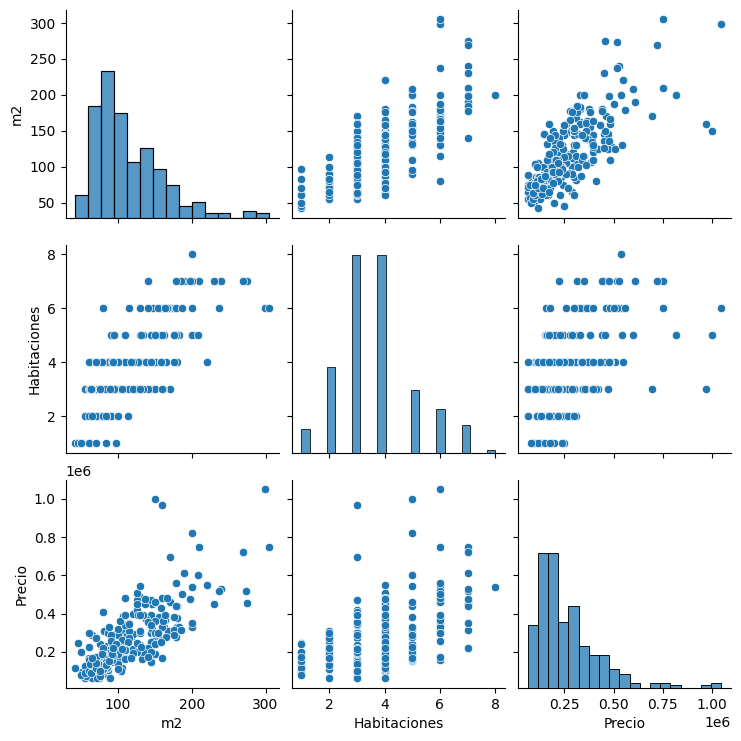

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

# Leer los ficheros de datos y pasarlos a matrices de numpy
pisos_train = pd.read_csv(Path+'PisosTrain.csv', sep = ";")

# Reshape it to a 2D array with 1 column
x1_train = pisos_train["m2"].to_numpy().reshape(-1, 1)
x2_train = pisos_train["Habitaciones"].to_numpy().reshape(-1, 1)

# Not needed the reshape.
y_train  = pisos_train["Precio"].to_numpy()

pisos_test  = pd.read_csv(Path+'PisosTest.csv',  sep = ";")
x1_test = pisos_test["m2"].to_numpy().reshape(-1, 1)
x2_test = pisos_test["Habitaciones"].to_numpy().reshape(-1, 1)

# Not needed the reshape
y_test  = pisos_test["Precio"].to_numpy()

# Mostrar los datos de entrenamiento
seaborn.pairplot(pisos_train)
plt.show()


Ahora ploteamos cada una de las variables con respecto a la variable explicada (precio) para analizar la posibilidad de datos espurios u otro tipo de anomalías.

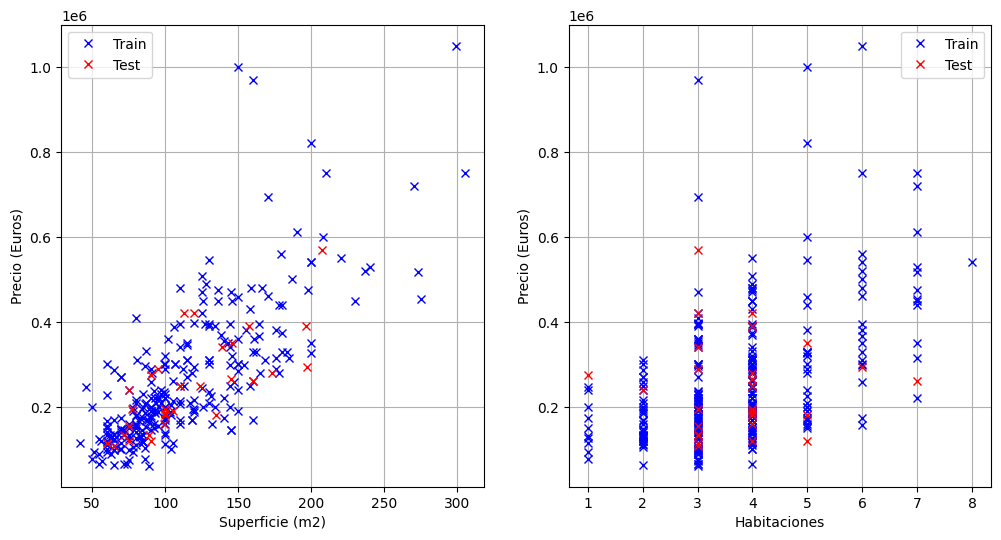

In [3]:
plt.figure(figsize=(12, 6))

# First plot
plt.subplot(1, 2, 1)
plt.plot(x1_train, y_train, 'bx', label='Train')
plt.plot(x1_test, y_test, 'rx', label='Test')
plt.xlabel('Superficie (m2)')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()

# Second plot
plt.subplot(1, 2, 2)
plt.plot(x2_train, y_train, 'bx', label='Train')
plt.plot(x2_test, y_test, 'rx', label='Test')
plt.xlabel('Habitaciones')
plt.ylabel('Precio (Euros)')
plt.legend()
plt.grid()

plt.show()

Observamos una tendencia creciente del precio respecto a la superficie y número de habitaciones (como era de esperar). Además, podemos ver la existencia de ciertos **datos espureos** en la primera gráfica, luego habrá que trabajar consecuentemente.

Para más información sobre técnicas de regresión, puedes consultar el libro "Pattern Recognition and Machine Learning" de Christopher M. Bishop.

---
## 1. Métricas

Como en el apartado anterior, hemos detectado una pequeña cantidad de datos espureos, vamos a utilizar las medidas **MAE**, **MRE** y por defecto, la medida $R^2$. Para ello, creamos una clase que calcule las diferentes medidas de error. La mayoría de ellas se pueden calcular directamente desde el módulo `sklearn` pero con fines prácticos, se van a implementar de 0.

In [4]:
from enum import IntFlag
import pandas as pd

class ErrorMetricsFlags(IntFlag):
    """
    Class to represent which error metrics to compute in a Linear Regression 
    analysis.

    It supports:

    - **RMSE**: Root Mean Squared Error 
    - **MAE**: Mean Absolute Error
    - **MedAE**: Median Absolute Error
    - **MRE**: Mean Relative Error
    - **MedRE**: Median Relative Error
    - **R2**: Coefficient of Determination (R^2)
    """

    RMSE = 1 << 0
    MAE = 1 << 1
    MedAE = 1 << 2
    MRE = 1 << 2
    MedRE = 1 << 3
    R2 = 1 << 4


class ErrorMetrics():
    def __init__(self, y_real:np.ndarray, y_pred:np.ndarray):
        self.y_real = y_real
        self.y_pred = y_pred
        self.n = y_real.shape[0]
    def RMSE(self):
        return np.sqrt(1/self.n*np.sum(np.pow((self.y_pred-self.y_real),2)))
    def MAE(self):
        return 1.0/self.n*sum(np.abs(self.y_pred-self.y_real))
    def MedAE(self):
        return np.median(np.abs(self.y_pred-self.y_real))
    def MRE(self):
        return 1/self.n*np.sum(np.abs(self.y_pred-self.y_real)/self.y_real)
    def medRE(self):
        return np.mean(np.abs(self.y_pred-self.y_real)/self.y_real)
    def R2(self):
        a = (self.y_real-self.y_pred).transpose() @ (self.y_real-self.y_pred)
        b = (self.y_real-np.mean(self.y_pred)).transpose() @ (self.y_real-np.mean(self.y_pred))
        return 1 - a/b
    
    def compute_metrics(self, flags:ErrorMetricsFlags, name:str, r:int):
        dic_ = {
            f'RMSE_{name}': [round(self.RMSE(), r)] if flags & ErrorMetricsFlags.RMSE else [],
            f'MAE_{name}': [round(self.MAE(), r)] if flags & ErrorMetricsFlags.MAE else [],
            f'MedAE_{name}': [round(self.MedAE(), r)] if flags & ErrorMetricsFlags.MedAE else [],
            f'MRE_{name}': [round(self.MRE(), r)] if flags & ErrorMetricsFlags.MRE else [],
            f'MedRE_{name}': [round(self.medRE(), r)] if flags & ErrorMetricsFlags.MedRE else [],
            f'R2_{name}': [round(self.R2(), r)] if flags & ErrorMetricsFlags.R2 else []
        }
        return dic_

flags = ErrorMetricsFlags.MAE | ErrorMetricsFlags.MRE | ErrorMetricsFlags.R2

También creamos una clase para calcular las métricas de un modelo concreto.

In [5]:
from sklearn.linear_model import LinearRegression
class LinearRegression:

    def __init__(   self, train_x:np.ndarray, train_y:np.ndarray,
                    test_x:np.ndarray, test_y:np.ndarray, model, name:str,
                    metrics:ErrorMetricsFlags, opt_name=None):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.model = model
        self.name = name
        self.metrics = metrics

        self.model.fit(self.train_x, self.train_y)

        if hasattr(self.model, 'named_steps'):
            self.intercept_ = self.model.named_steps[opt_name].intercept_
            self.coef_ = self.model.named_steps[opt_name].coef_
        else:
            self.intercept_ = self.model.intercept_
            self.coef_ = self.model.coef_
            
        if isinstance(self.intercept_, np.ndarray):
            self.intercept_ = self.intercept_[0]


    def get_weights(self, r=2):
        return [round(float(self.intercept_), r)] + [round(float(x) , r) for x in self.coef_]
    

    def plot_model(self, x_index, xlabel, ylabel):
        # Create a two col figure
        plt.figure(figsize=(12, 6))
        
        # Get variable given the index
        x_test = self.test_x[:,x_index].reshape(-1,1)
        x_train = self.train_x[:,x_index].reshape(-1,1)

        # --------------------------
        # Train plot

        # Create a grid to plot a line
        x_grid_train = np.zeros(shape=(100,self.test_x.shape[1])) 
        x_grid_train[:,x_index] = np.linspace(np.min(x_train), np.max(x_train), 100)
        y_grid_train = self.model.predict(x_grid_train)

        
        plt.subplot(1,2,1)
        plt.plot(x_train, self.train_y, 'bx', label='Train')
        plt.plot(x_grid_train, y_grid_train, 'k-', label="Pred")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

        # --------------------------
        # Test plot

        # Create a grid to plot a line
        x_grid_test = np.linspace(np.min(x_test), np.max(x_test), 100).reshape(-1, 1)
        y_grid_test = self.model.predict(x_grid_train)

        plt.subplot(1,2,2)
        plt.plot(x_test, y_test, 'bx', label='Test')
        plt.plot(x_grid_test, y_grid_test, 'k-', label="Pred")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid()

    def pretty_print(self, r=2):
        from IPython.display import display, Markdown
        all_variables = "+".join([f" {round(x, r)} \cdot x_{i+1} " for (i,x) in enumerate(self.coef_)])
        all_line = f"$$\hat{{y}} = {round(self.intercept_, r)} +" + all_variables + " $$"
        display(Markdown(all_line))
    
    def compute_metrics(self, r=2):

        y_train_predicted = self.model.predict(self.train_x)
        y_test_predicted = self.model.predict(self.test_x)

        # Compute the metrics for training
        em_train = ErrorMetrics(y_train, y_train_predicted)
        metrics_train = em_train.compute_metrics(self.metrics, "train", r)

        em_test = ErrorMetrics(y_test, y_test_predicted)
        metrics_test = em_test.compute_metrics(self.metrics, "test", r)

        metrics = {"Name":self.name,**metrics_train, **metrics_test}
        metrics = {a:b for (a,b) in metrics.items() if b}

        return pd.DataFrame(metrics)

----
## 2. Regresión Monovariable

Para este primer apartado, vamos a utilizar un modelo de **regresión monovariable**, para predecir el precio de los pisos en función de sus supercicie, utilizando la ecuación normal. Es decir, tenemos $X\in \mathbb{M}^{n\times 2}$ donde $n$ es el número de muestras y $X = [\mathbf{1}, X_{sup}]$ y suponemos $\hat{y} = Xw$ donde $w\in\mathbb{R}^n$ es una matriz de pesos. Así, la ecuación normal nos da los valores de estos pesos que minimizan el error cuadrado $(y-\hat{y})^T(y-\hat{y})$:
$$
w = (X^TX)^{-1}X^Ty
$$
Así, $\hat{y}$ se puede interpretar como la proyección de $y$ sobre el subespacio $\{\mathbf{1}, X_{sup}\}$ (ver sección **11.2.2.1** de [*Probabilistic Machine Learning: An Introduction*](https://doi.org/10.7551/mitpress/14864.001.0001)).

Esta solución es analítica y se puede calcular de dos formas equivalentes:
- Obteniendo la solución lineal del sistema:
$$
(X^TX)w = X^Ty
$$
- Utilizando la función `LinearRegression()` de `scikit-learn`

In [6]:
## código
n = x1_train.shape[0]
X_ = np.concat([np.ones((n,1)), x1_train], axis=1)

w = np.linalg.solve(X_.transpose() @ X_, X_.transpose() @ y_train)

print("Weights : ", w)

Weights :  [-34313.38797202   2608.20943472]


Veamos que sale los mismos valores usando la función de librería

In [7]:
from sklearn import linear_model

one_variable_model = LinearRegression(  x1_train, y_train, 
                                        x1_test, y_test, 
                                        linear_model.LinearRegression(),
                                        "One-Variable", flags)

one_variable_model.get_weights(r=10)


[-34313.3879720236, 2608.2094347218]

Vemos que ambos resultados son idénticos. Entonces la recta resultante es:

In [8]:
one_variable_model.pretty_print(r=0)

$$\hat{y} = -34313.0 + 2608.0 \cdot x_1  $$

La ploteamos junto a los datos de entrenamiento:

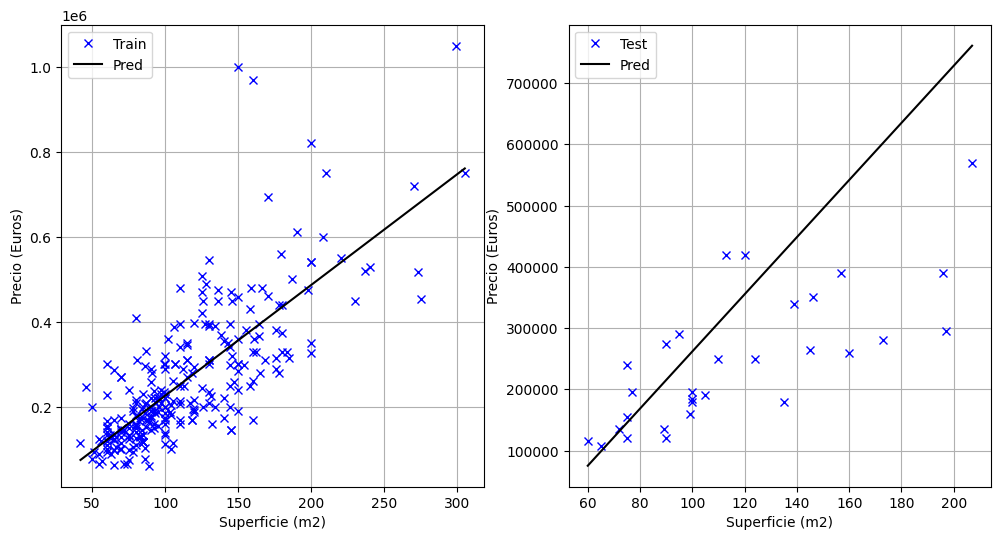

In [9]:
one_variable_model.plot_model(0, 'Superficie (m2)', 'Precio (Euros)')

Además, para un análisis cuantitativo, calculamos las métricas de error.

In [10]:
one_variable_model.compute_metrics(r=10)

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,One-Variable,69534.930002,50507.312333,0.300915,0.583546,63936.474539,56182.927196,0.274446,0.479026


Aquí podemos ver que el ajuste no es muy bueno ya que se tiene un $R^2$ relativamente bajo para los datos de test.

----
## 3. Regresión Multivariable
Ahora vamos a explicar el precio en función de la superficie y el número total de habitaciones. Vamos a aplicar también la fórmula normal pero ahora $X = [\mathbf{1}, X_{sup}, X_{hab}] \in \mathbb{M}^{n\times 3}$. Esta vez, directamente vamos a usar la función de librería. Entonces, la ecuación del plano es :

In [11]:
x_train = np.concat([x1_train, x2_train], axis=1)
x_test = np.concat([x1_test, x2_test], axis=1)
two_variables_model = LinearRegression(  x_train, y_train, 
                                        x_test, y_test, 
                                        linear_model.LinearRegression(),
                                        "Two-Variables", flags)
two_variables_model.pretty_print()

$$\hat{y} = -12132.91 + 3028.74 \cdot x_1 + -18852.83 \cdot x_2  $$

donde $x_1$ es la superficie y $x_2$ es el número de habitaciones. Aquí se aprecia que el número de habitaciones afecta de forma negativa al precio, algo que no parece tener mucho sentido. Sin embargo, esto se debe a que las dos covariables número de habitaciones y superficie no son independientes (de hecho son muy dependientes), haciendo que el modelo *aumente* el coeficiente de la superficie con respecto al modelo anterior y lo *ajuste* con el número de habitaciones. En efecto, podemos calcular la matriz de correlación de estas dos variables:

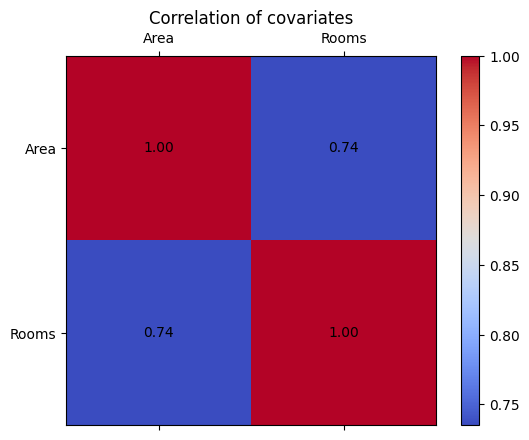

In [12]:
data = np.concatenate([x_test, x_train], axis=0)
corr_matrix = np.corrcoef(data.transpose())

fig, ax = plt.subplots()
cax = ax.matshow(corr_matrix, cmap='coolwarm')

# Add the value of each cell in text in the center of the cell
for (i, j), val in np.ndenumerate(corr_matrix):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='black')

# Set the ticks and labels
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Area", "Rooms"])
ax.set_yticklabels(["Area", "Rooms"])

# Add a title
plt.title("Correlation of covariates")

plt.colorbar(cax)
plt.show()

con un valor $\sigma =0.74$ muy cercano a $1$. Habría que valorar si la inclusión de ambas variables es necesaria debido a esta gran correlación.

Por otro lado, las métricas de este modelo son las siguientes

In [13]:
two_variables_model.compute_metrics(r=2)

,Name,MAE_train,MedAE_train,MRE_train,R2_train,MAE_test,MedAE_test,MRE_test,R2_test
0,Two-Variables,69089.3,48215.88,0.3,0.6,55256.44,36675.14,0.23,0.55


Aquí podemos apreciar una ligera mejora del $R^2$ del modelo, indicando que al añadir el número de habitaciones, se ha explicado mejor el precio de la vivienda. 

----
## 4. Regresión Multivariable con Descenso de Gradiente
Ahora vamos a realizar lo mismo que en el apartado anterior pero utilizando la técnica de descenso de gradiente estocástico ( ver apartado 8.4 de [*Probabilistic Machine Learning: An Introduction*](https://doi.org/10.7551/mitpress/14864.001.0001)). 

En este algoritmo se tiene un hiperparámetro $\alpha$ llamado *learning rate* o **tasa de aprendizaje** que representa cúanto se mueven los pesos respecto a su gradiente. Además, también hay que determinar qué función de coste se va a usar. En nuestro caso, se va a utilizar la función de mínimos cuadrados.

In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

model_SGD = make_pipeline(SGDRegressor(loss='squared_error'))

SGD_model = LinearRegression(x_train, y_train, x_test, y_test, model_SGD, "SGD-multivariate", flags, opt_name='sgdregressor')

SGD_model.pretty_print()

$$\hat{y} = 41827788141.54 + -19672745463.58 \cdot x_1 + 136134965349.6 \cdot x_2  $$

----
## 5. Regresión Multivariable con Descenso de Gradiente y coste de Huber

### Referencias

Murphy, K. P. (2022). *Probabilistic Machine Learning: An Introduction*. MIT Press.